In [426]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics

# pd.options.mode.chained_assignment = None  # default='warn'

<h2>Getting stock data</h2>

In [427]:
def get_yahoo_stock_data(symbol, columns=None, dfrom='2020-1-1'):
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period='1d', start=dfrom)
    tickerDf["Date_Week"] = tickerDf.index.day_of_week
    targetDf = tickerDf if columns is None else tickerDf[columns]
    return targetDf

In [567]:
def gen_features(data):
    # create a percentage change feature
    data['pct_change'] = data.Close.pct_change()
    data['1d_before_close'] = data['Close'].shift(periods=1)
    data['1d_before_volume'] = data['Volume'].shift(periods=1)
    data['1d_before_high'] = data['High'].shift(periods=1)
    data['1d_before_low'] = data['Low'].shift(periods=1)
    data['2d_before_close'] = data['Close'].shift(periods=2)
    data['2d_before_volume'] = data['Volume'].shift(periods=2)
    data['2d_before_high'] = data['High'].shift(periods=2)
    data['2d_before_low'] = data['Low'].shift(periods=2)

    # scale data
    #scaler = StandardScaler()
    #data['1d_before_close'] = scaler.fit_transform(np.array(data['1d_before_close']).reshape(-1,1))    
    #data['1d_before_volume'] = scaler.fit_transform(np.array(data['1d_before_volume']).reshape(-1,1))    
    #data['1d_before_high'] = scaler.fit_transform(np.array(data['1d_before_high']).reshape(-1,1))    
    #data['1d_before_low'] = scaler.fit_transform(np.array(data['1d_before_low']).reshape(-1,1))    
    #data['2d_before_close'] = scaler.fit_transform(np.array(data['2d_before_close']).reshape(-1,1))    
    #data['2d_before_volume'] = scaler.fit_transform(np.array(data['2d_before_volume']).reshape(-1,1))    
    #data['2d_before_high'] = scaler.fit_transform(np.array(data['2d_before_high']).reshape(-1,1))    
    #data['2d_before_low'] = scaler.fit_transform(np.array(data['2d_before_low']).reshape(-1,1))   
    
    #feature_pd = data.filter(regex='pct_change|Close|1d_*|2d_*|f_price_change|f_volume_change|f_sign|f_date_week|f_volume_noise|f_price_noise')[:-2]         # first 2 record is missing 1d & 2d close and volume
    #feature_pd.insert(0, 'pct_change', feature_pd.pop('pct_change'))

    feature_pd = data.filter(regex='pct_change|Close|1d_*|2d_*')[2:]
    return feature_pd


<h3>Test above functions</h3>

In [568]:
# ["Date_Week", "Open", "High", "Low", "Close", "Volume"]
TSM_df = get_yahoo_stock_data("TSLA", columns=None, dfrom='2010-1-1')
TSM_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date_Week
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0,1
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0,2
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0,3
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0,4
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0,1
...,...,...,...,...,...,...,...,...
2022-10-07 00:00:00-04:00,233.940002,234.570007,222.020004,223.070007,83592300,0,0.0,4
2022-10-10 00:00:00-04:00,223.929993,226.990005,218.360001,222.960007,67925000,0,0.0,0
2022-10-11 00:00:00-04:00,220.949997,225.750000,215.000000,216.500000,77013200,0,0.0,1


In [569]:
train_df = gen_features(TSM_df)
train_df

,Close,pct_change,1d_before_close,1d_before_volume,1d_before_high,1d_before_low,2d_before_close,2d_before_volume,2d_before_high,2d_before_low
Date,,,,,,,,,,
2010-07-01 00:00:00-04:00,1.464000,-0.078473,1.588667,257806500.0,2.028000,1.553333,1.592667,281494500.0,1.666667,1.169333
2010-07-02 00:00:00-04:00,1.280000,-0.125683,1.464000,123282000.0,1.728000,1.351333,1.588667,257806500.0,2.028000,1.553333
2010-07-06 00:00:00-04:00,1.074000,-0.160937,1.280000,77097000.0,1.540000,1.247333,1.464000,123282000.0,1.728000,1.351333
2010-07-07 00:00:00-04:00,1.053333,-0.019243,1.074000,103003500.0,1.333333,1.055333,1.280000,77097000.0,1.540000,1.247333
2010-07-08 00:00:00-04:00,1.164000,0.105064,1.053333,103825500.0,1.108667,0.998667,1.074000,103003500.0,1.333333,1.055333
...,...,...,...,...,...,...,...,...,...,...
2022-10-07 00:00:00-04:00,223.070007,-0.063243,238.130005,69298400.0,244.580002,235.350006,240.809998,86982700.0,246.669998,233.270004
2022-10-10 00:00:00-04:00,222.960007,-0.000493,223.070007,83592300.0,234.570007,222.020004,238.130005,69298400.0,244.580002,235.350006
2022-10-11 00:00:00-04:00,216.500000,-0.028974,222.960007,67925000.0,226.990005,218.360001,223.070007,83592300.0,234.570007,222.020004


<AxesSubplot:xlabel='Date'>

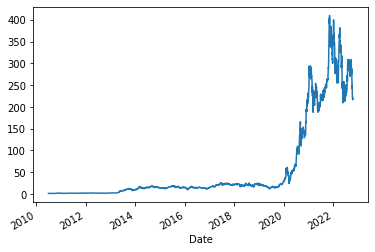

In [570]:
#TSM_df.regress_y.cumsum().plot()
train_df["Close"].plot()

<H2>Train Data</H2>

In [571]:
train_df = gen_features(get_yahoo_stock_data("TSLA", columns=None, dfrom='2010-1-1'))
train_df

,Close,pct_change,1d_before_close,1d_before_volume,1d_before_high,1d_before_low,2d_before_close,2d_before_volume,2d_before_high,2d_before_low
Date,,,,,,,,,,
2010-07-01 00:00:00-04:00,1.464000,-0.078473,1.588667,257806500.0,2.028000,1.553333,1.592667,281494500.0,1.666667,1.169333
2010-07-02 00:00:00-04:00,1.280000,-0.125683,1.464000,123282000.0,1.728000,1.351333,1.588667,257806500.0,2.028000,1.553333
2010-07-06 00:00:00-04:00,1.074000,-0.160937,1.280000,77097000.0,1.540000,1.247333,1.464000,123282000.0,1.728000,1.351333
2010-07-07 00:00:00-04:00,1.053333,-0.019243,1.074000,103003500.0,1.333333,1.055333,1.280000,77097000.0,1.540000,1.247333
2010-07-08 00:00:00-04:00,1.164000,0.105064,1.053333,103825500.0,1.108667,0.998667,1.074000,103003500.0,1.333333,1.055333
...,...,...,...,...,...,...,...,...,...,...
2022-10-07 00:00:00-04:00,223.070007,-0.063243,238.130005,69298400.0,244.580002,235.350006,240.809998,86982700.0,246.669998,233.270004
2022-10-10 00:00:00-04:00,222.960007,-0.000493,223.070007,83592300.0,234.570007,222.020004,238.130005,69298400.0,244.580002,235.350006
2022-10-11 00:00:00-04:00,216.500000,-0.028974,222.960007,67925000.0,226.990005,218.360001,223.070007,83592300.0,234.570007,222.020004


In [585]:
feature_np = train_df.values
train_x = feature_np[:, 2:]
train_y = feature_np[:, 0]      # First column, if 1 get pct_change
yesterday_close = feature_np[:, 2]     
train_y_classification = np.where(train_y > yesterday_close, 1, 0)
train_x[:5], train_y[:5], train_y_classification[:5]

(array([[1.58866704e+00, 2.57806500e+08, 2.02800012e+00, 1.55333304e+00,
         1.59266698e+00, 2.81494500e+08, 1.66666698e+00, 1.16933298e+00],
        [1.46399999e+00, 1.23282000e+08, 1.72800004e+00, 1.35133302e+00,
         1.58866704e+00, 2.57806500e+08, 2.02800012e+00, 1.55333304e+00],
        [1.27999997e+00, 7.70970000e+07, 1.53999996e+00, 1.24733305e+00,
         1.46399999e+00, 1.23282000e+08, 1.72800004e+00, 1.35133302e+00],
        [1.07400000e+00, 1.03003500e+08, 1.33333302e+00, 1.05533302e+00,
         1.27999997e+00, 7.70970000e+07, 1.53999996e+00, 1.24733305e+00],
        [1.05333304e+00, 1.03825500e+08, 1.10866702e+00, 9.98667002e-01,
         1.07400000e+00, 1.03003500e+08, 1.33333302e+00, 1.05533302e+00]]),
 array([1.46399999, 1.27999997, 1.074     , 1.05333304, 1.16400003]),
 array([0, 0, 0, 0, 1]))

<H2>Test Data</H2>

In [573]:
test_df = gen_features(get_yahoo_stock_data("GOOG", columns=None, dfrom='2022-1-1'))
test_df

,Close,pct_change,1d_before_close,1d_before_volume,1d_before_high,1d_before_low,2d_before_close,2d_before_volume,2d_before_high,2d_before_low
Date,,,,,,,,,,
2022-01-05 00:00:00-05:00,137.653503,-0.046830,144.416504,22928000.0,146.610001,143.816147,145.074493,25214000.0,145.550003,143.502502
2022-01-06 00:00:00-05:00,137.550995,-0.000745,137.653503,49642000.0,144.298004,137.523499,144.416504,22928000.0,146.610001,143.816147
2022-01-07 00:00:00-05:00,137.004501,-0.003973,137.550995,29050000.0,139.686005,136.763504,137.653503,49642000.0,144.298004,137.523499
2022-01-10 00:00:00-05:00,138.574005,0.011456,137.004501,19408000.0,138.254745,135.789001,137.550995,29050000.0,139.686005,136.763504
2022-01-11 00:00:00-05:00,140.017502,0.010417,138.574005,34096000.0,138.639999,133.140503,137.004501,19408000.0,138.254745,135.789001
...,...,...,...,...,...,...,...,...,...,...
2022-10-07 00:00:00-04:00,99.570000,-0.026115,102.239998,17156200.0,103.730003,101.500000,102.220001,18475500.0,102.739998,99.739998
2022-10-10 00:00:00-04:00,98.709999,-0.008637,99.570000,24232300.0,101.419998,99.209999,102.239998,17156200.0,103.730003,101.500000
2022-10-11 00:00:00-04:00,98.050003,-0.006686,98.709999,16529900.0,99.989998,97.870003,99.570000,24232300.0,101.419998,99.209999


In [586]:
feature_np = test_df.values
test_x = feature_np[:, 2:]
test_y = feature_np[:, 0]
yesterday_close = feature_np[:, 2]     
test_y_classification = np.where(test_y > yesterday_close, 1, 0)
test_x[:5], test_y[:5], test_y_classification[:5]

(array([[1.44416504e+02, 2.29280000e+07, 1.46610001e+02, 1.43816147e+02,
         1.45074493e+02, 2.52140000e+07, 1.45550003e+02, 1.43502502e+02],
        [1.37653503e+02, 4.96420000e+07, 1.44298004e+02, 1.37523499e+02,
         1.44416504e+02, 2.29280000e+07, 1.46610001e+02, 1.43816147e+02],
        [1.37550995e+02, 2.90500000e+07, 1.39686005e+02, 1.36763504e+02,
         1.37653503e+02, 4.96420000e+07, 1.44298004e+02, 1.37523499e+02],
        [1.37004501e+02, 1.94080000e+07, 1.38254745e+02, 1.35789001e+02,
         1.37550995e+02, 2.90500000e+07, 1.39686005e+02, 1.36763504e+02],
        [1.38574005e+02, 3.40960000e+07, 1.38639999e+02, 1.33140503e+02,
         1.37004501e+02, 1.94080000e+07, 1.38254745e+02, 1.35789001e+02]]),
 array([137.65350342, 137.55099487, 137.00450134, 138.57400513,
        140.01750183]),
 array([0, 0, 0, 1, 1]))

In [587]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress):
    estimator.fit(train_x, train_y_regress)
    #print(train_y_regress)
    test_y_predict_regress = estimator.predict(test_x)
    #print(test_y_regress)
    #print(test_y_predict_regress)
    plt.plot(test_y_regress)
    plt.plot(test_y_predict_regress)


    scores = cross_val_score(estimator, train_x, train_y_regress, cv=10, scoring="neg_mean_squared_error")
    mean_sc = np.mean(np.sqrt(-scores))
    print('RMSE: ' + str(mean_sc))

    return estimator

<h3>Test Different Models</h3>

RMSE: 2.3118354737062736


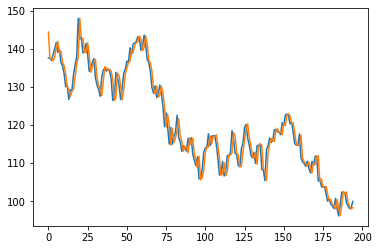

In [588]:
estimator = LinearRegression()
model = regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress)

RMSE: 14.274730277440318


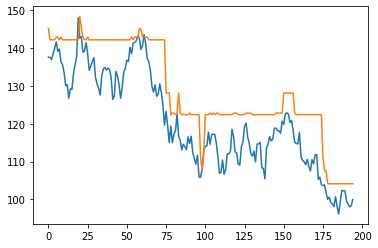

In [589]:
from sklearn.ensemble import AdaBoostRegressor

estimator3 = AdaBoostRegressor(n_estimators=100)
model = regress_process(estimator3, train_x, train_y_regress, test_x, test_y_regress)

RMSE: 8.658040033007838


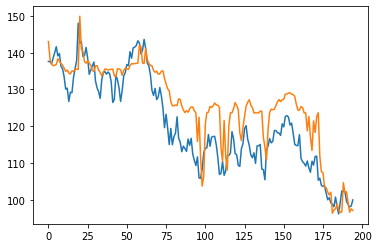

In [590]:
from sklearn.ensemble import RandomForestRegressor

estimator4 = RandomForestRegressor(n_estimators=100)
model = regress_process(estimator4, train_x, train_y_regress, test_x, test_y_regress)

<H3>Test Prediction</H3>

In [591]:
def gen_predict_features(stock_code):
    # predict today
    stock_df = get_yahoo_stock_data(stock_code, columns=None, dfrom='2021-1-1')
    data_1d_before = stock_df[-1:][["Close", "Volume", "High", "Low"]].values
    print(data_1d_before)

    predict_df = gen_features(stock_df)
    predict_df = predict_df[-1:]
    data_2d_before = predict_df[["1d_before_close", "1d_before_volume", "1d_before_high", "1d_before_low"]].values

    return np.append(data_1d_before[0], data_2d_before[0])

In [592]:
predict_x = gen_predict_features("TSLA")
predict_x

[[2.20300903e+02 5.36326740e+07 2.22449997e+02 2.06220001e+02]]


array([2.20300903e+02, 5.36326740e+07, 2.22449997e+02, 2.06220001e+02,
       2.17240005e+02, 6.67250000e+07, 2.19300003e+02, 2.11509995e+02])

In [593]:
predict_result = model.predict([predict_x])
predict_result

array([219.33789169])

<h3>Classification instead of regression</h3>

In [594]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification):
    estimator.fit(train_x, train_y_classification)
    test_y_predict_classification = estimator.predict(test_x)
    print("{} accuracy = {:.2f}". format(estimator.__class__.__name__, metrics.accuracy_score(test_y_classification, test_y_predict_classification)))

    scores = cross_val_score(estimator, train_x, train_y_classification, cv=10, scoring="accuracy")
    mean_sc = np.mean(scores)
    print('cross validation accuracy mean: {:.2f}'.format(mean_sc))

In [595]:
estimator = LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

LogisticRegression accuracy = 0.47
cross validation accuracy mean: 0.52


In [596]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

RandomForestClassifier accuracy = 0.48
cross validation accuracy mean: 0.49


<h3>Split data to train and test</h3>

In [597]:
def train_test_split_xy(estimator, x, y, test_size=0.5, random_state=0):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, random_state=random_state)
    print(x.shape, y.shape)
    print(train_x.shape, train_y.shape)
    print(test_x.shape, test_y.shape)

    clf = estimator.fit(train_x, train_y)
    predictions = clf.predict(test_x)

    print("accuracy = %.2f" % (metrics.accuracy_score(test_y, predictions)))

    print("precision_score = %.2f" % (metrics.precision_score(test_y, predictions)))

    print("recall score = %.2f" % (metrics.recall_score(test_y, predictions)))
    
    return test_y, predictions

In [598]:
test_y, predicts = train_test_split_xy(estimator, train_x, train_y_classification)

(3094, 8) (3094,)
(1547, 8) (1547,)
(1547, 8) (1547,)
accuracy = 0.50
precision_score = 0.52
recall score = 0.52


<h3>Confusion matrix</h3>

In [599]:
def confusion_matrix_with_report(test_y, predictions):
    confusion_matrix = metrics.confusion_matrix(test_y, predictions)
    print("        Predicted")
    print("        |  0  |  1  |")
    print("        |-----|-----|")
    print("       0| %3d | %3d |" % (confusion_matrix[0,0], confusion_matrix[0,1]))
    print("Actual  |-----|-----|")
    print("       1| %3d | %3d |" % (confusion_matrix[1,0], confusion_matrix[1,1]))
    print("        |-----|-----|")

    print(metrics.classification_report(test_y, predictions))

confusion_matrix_with_report(test_y, predicts)

        Predicted
        |  0  |  1  |
        |-----|-----|
       0| 360 | 381 |
Actual  |-----|-----|
       1| 387 | 419 |
        |-----|-----|
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       741
           1       0.52      0.52      0.52       806

    accuracy                           0.50      1547
   macro avg       0.50      0.50      0.50      1547
weighted avg       0.50      0.50      0.50      1547

